---
## Create Dataset (link to BigQuery table)

From the Console:
- Go to Vertex AI
- Selected `Datasets`
- Select `CREATE DATASET`

<img src="../architectures/notebooks/02a_screenshots/ds_1.png" width="50%">

- Name the dataset `02a`
- Select `Tabular` and `Regression/classification`
    - [More on Model Types](https://cloud.google.com/vertex-ai/docs/start/automl-model-types)
- Click `Create`

<img src="../architectures/notebooks/02a_screenshots/ds_2.png" width="50%">

- Under Select a data source pick `Select a table or view from BigQuery`
- Enter the BigQuery path (or browse) to the prepped table created in notebook 01
- Click `CONTINUE`

<img src="../architectures/notebooks/02a_screenshots/ds_3.png" width="50%">

- The `ANALYZE` tab for the dataset will be displayed for review:

<img src="../architectures/notebooks/02a_screenshots/ds_4.png" width="50%">

- Going back to the `Datasets` dashboard will display the registered dataset

<img src="../architectures/notebooks/02a_screenshots/ds_5.png" width="50%">

---
## Train Model with AutoML

On The Vertex AI console, select `Training`:

<img src="../architectures/notebooks/02a_screenshots/train_1.png" width="50%">

Next to `Training` (near the top), select `CREATE`
- For Dataset enter `02a`
- For Objective make sure `Classification` is selected
- Use `AutoML` for the method
- Click `CONTINUE`

<img src="../architectures/notebooks/02a_screenshots/train_2.png" width="50%">

For `Model Details`:
- Keep the default `Model name` which appends a datetime to the end of the dataset name
- For `Target column` select the column to train predictions for
- Expand `ADVANCED OPTIONS`:
    - Select `Manual` for the Data split method
    - Select the `splits` variables that was created in Notebook 01
- Click `CONTINUE`

<img src="../architectures/notebooks/02a_screenshots/train_3.png" width="50%">

For `Training options`:
- Click the `-` symbol next to any rows for variables that should be excluded from training, like the `transaction_id`
- More on Adavanced Options:
    - [Model Weights](https://cloud.google.com/vertex-ai/docs/datasets/prepare-tabular#weight)
    - [Optimization Objectives](https://cloud.google.com/vertex-ai/docs/training/tabular-opt-obj)
        - Pick AUC PR (Due to imbalance in Class)
- Click `CONTINUE`

<img src="../architectures/notebooks/02a_screenshots/train_4.png" width="50%">

For `Compute and pricing`:
- Enter a `Budget` of 1 node hour
    - A guide for choosing the right amount of time can be found [here](https://cloud.google.com/vertex-ai/docs/training/automl-console#tabular): 
- Make sure `Enable early stopping` is toggled on
- Click `START TRAINING`

<img src="../architectures/notebooks/02a_screenshots/train_5.png" width="50%">

Return to the Vertex AI console `Training` Menu:
- Once the model completes training the name will be accompanied by a green check mark

<img src="../architectures/notebooks/02a_screenshots/train_6.png" width="50%">

---
## Model: Evaluate, Select, Deploy

On the Vertex AI console, select `Models`

<img src="../architectures/notebooks/02a_screenshots/model_1.png" width="50%">

Select the model that was just trained - starts with `02a`:
- This brings up the `EVALUATE` tab for the model

<img src="../architectures/notebooks/02a_screenshots/model_2.png" width="50%">

Select the tab labeled `DEPLOY & TEST`:

<img src="../architectures/notebooks/02a_screenshots/model_3.png" width="50%">

---
## Endpoint

While still on the Vetex AI `Models` section with the `DEPLOY & TEST` tab selected:
- select `DEPLOY TO ENDPOINT`

<img src="../architectures/notebooks/02a_screenshots/model_3.png" width="50%">

In the `Deploy to endpoint` menus, complete `Define your endpoint`:
- For Endpoint name use `02a`
- keep defaults for location and Access
- Select `CONTINUE`

<img src="../architectures/notebooks/02a_screenshots/endpoint_1.png" width="50%">

In the `Model settings` section:
- Traffic split should be 100
- minimum number of computes nodes is 1
- keep the remaining default values for max nodes, scaling, logging and explainability
- Select `CONTINUE`

<img src="../architectures/notebooks/02a_screenshots/endpoint_2.png" width="50%">

In the `Model monitoring` section:
- Toggle `Enable model monitoring for this endpoint` on
    - for monitoring job use the name `02a`
    - use defaults for the other menue items
- Select `CONTINUE`

<img src="../architectures/notebooks/02a_screenshots/endpoint_3.png" width="50%">

In the `Monitoring objectives` section:
- Select `Prediction Drift Detection` under Monitoring objective
- Select `DEPLOY`

<img src="../architectures/notebooks/02a_screenshots/endpoint_4.png" width="50%">

Once the model is done being deployed to the endpoint, click the `Endpoints` section of Vertex AI:
- Select the endpoint that starts with `02a`
- Review the endpoint dashboard for the deployed model

<img src="../architectures/notebooks/02a_screenshots/endpoint_5.png" width="50%">


---
## Batch

In the Verex AI console select the `Batch predictions` section:

<img src="../architectures/notebooks/02a_screenshots/batch_1.png" width="50%">

Select `Create`:
- name the prediction `02a`
- for model name select the model that starts with `02a`
- for Select source, pick BigQuery table
- provide the location of the BigQuery source table
- for storage location pick output format of BigQuery
- provide the project for output in BigQuery
- select `Generate feature importance`
- select `Enable feature attributions for this model`
- select `CREATE`

<img src="../architectures/notebooks/02a_screenshots/batch_2.png" width="50%">

Once the batch prediction job completes it will be listed with a green checkmark under `Batch Predictions`

<img src="../architectures/notebooks/02a_screenshots/batch_3.png" width="50%">

Selecting the batch prediction job that starts with `02a` bring up the details of the prediction job

<img src="../architectures/notebooks/02a_screenshots/batch_4.png" width="50%">

Select the linked BigQuery output table next to `Export location`:

<img src="../architectures/notebooks/02a_screenshots/batch_5.png" width="50%">

---
## Prediction

inputs:

In [2]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'ivory-plane-372610'

In [14]:
REGION = 'us-central1'
DATANAME = 'fraud'
NOTEBOOK = 'untitled_1672326136251'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [15]:
from google.cloud import aiplatform

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

clients:

In [16]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

parameters:

In [17]:
DIR = f"temp/{NOTEBOOK}"

environment:

In [18]:
!rm -rf {DIR}
!mkdir -p {DIR}

### Prepare a record for prediction: instance and parameters lists

In [8]:
pred = bigquery.query(query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits='TEST' LIMIT 10").to_dataframe()

In [9]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,150738,2.143751,0.183322,-2.388584,0.515847,0.665733,-1.735340,0.950967,-0.600620,-0.005817,...,-0.169722,-0.007745,0.644994,0.733979,-0.126362,-0.096854,0.0,0,610dccc8-a94f-4b3a-92a8-63e01144f63b,TEST
1,136246,-2.075902,-0.739989,3.275072,4.722726,2.568343,0.928863,-0.968300,-0.472463,-0.410197,...,-1.220360,0.796193,-0.390845,0.096030,-0.484931,-0.952692,0.0,0,79255e0e-33e0-4f9c-a014-1f52b55e3b57,TEST
2,145301,-1.160897,1.569236,-0.959218,-1.325931,0.467754,-0.492321,0.403802,0.859218,-0.250481,...,-0.202913,-1.125976,0.065774,-0.059594,0.192667,0.128155,0.0,0,ef53a2fc-3aba-424e-8e35-caf76fa3c968,TEST
3,124668,2.049097,-0.023146,-1.534728,0.369062,0.185919,-1.135992,0.404738,-0.326297,0.111668,...,0.080560,0.139479,0.138779,0.535932,-0.099302,-0.086803,0.0,0,9edfc2a6-3c72-412a-9b1a-199bd9e7e154,TEST


In [19]:
#newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')[0]
newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET])]].to_dict(orient='records')[0]
#newob

Need to understand the format of variables that the predictions expect.  AutoML may convert the type of some variables. The following cells retrieve the model from the endpoint and its schemata:

In [20]:
newob['Time'] = str(newob['Time'])

In [21]:
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())

In [27]:
newob

{'Time': '150738',
 'V1': 2.1437507566996796,
 'V2': 0.183321526416093,
 'V3': -2.38858375636735,
 'V4': 0.515847416510303,
 'V5': 0.665733161131883,
 'V6': -1.73534049874417,
 'V7': 0.9509666524123549,
 'V8': -0.600619803836902,
 'V9': -0.00581676860900149,
 'V10': 0.295750822004403,
 'V11': -0.974677392874006,
 'V12': -0.398013601967856,
 'V13': -1.18333941703157,
 'V14': 1.04173283377388,
 'V15': -0.11180729817575999,
 'V16': -0.8027343789958321,
 'V17': -0.0158236218155932,
 'V18': -0.636531058485573,
 'V19': -0.036669592599691006,
 'V20': -0.33224253230361,
 'V21': 0.25526133163050196,
 'V22': 0.902599477817529,
 'V23': -0.169721578592358,
 'V24': -0.0077451364826243,
 'V25': 0.64499415151851,
 'V26': 0.733978924299476,
 'V27': -0.12636220011930302,
 'V28': -0.0968535450952978,
 'Amount': 0.0,
 'splits': 'TEST'}

### Get Predictions: Python Client

In [23]:
endpoint = aiplatform.Endpoint.list(filter=f'display_name=endpoint')[0]
endpoint.display_name

'endpoint'

In [24]:
prediction = endpoint.predict(instances=instances, parameters=parameters)
prediction

Prediction(predictions=[{'classes': ['0', '1'], 'scores': [0.999306321144104, 0.000693720590788871]}], deployed_model_id='4870269163047747584', model_version_id='1', model_resource_name='projects/24006034033/locations/us-central1/models/2895007518864441344', explanations=None)

In [28]:
prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]

'0'

### Get Predictions: REST

In [30]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newob]}))

In [31]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "classes": [
        "0",
        "1"
      ],
      "scores": [
        0.999306321144104,
        0.000693720590788871
      ]
    }
  ],
  "deployedModelId": "4870269163047747584",
  "model": "projects/24006034033/locations/us-central1/models/2895007518864441344",
  "modelDisplayName": "untitled_1672326136251",
  "modelVersionId": "1"
}


### Get Predictions: gcloud (CLI)

In [17]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'classes': ['0', '1'], 'scores': [0.7969269156455994, 0.2030730545520782]}]


---
## Explanations
Interpretation Guide
- https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular

In [18]:
explanation = endpoint.explain(instances=instances, parameters=parameters)

In [19]:
explanation.predictions

[{'scores': [0.7969269156455994, 0.2030730545520782], 'classes': ['0', '1']}]

In [20]:
print("attribution:")
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index",explanation.explanations[0].attributions[0].output_index)
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.7983816862106323
instance output 0.7969269156455994
output_index [0]
output display value 0
approximation error 0.01869985340771198


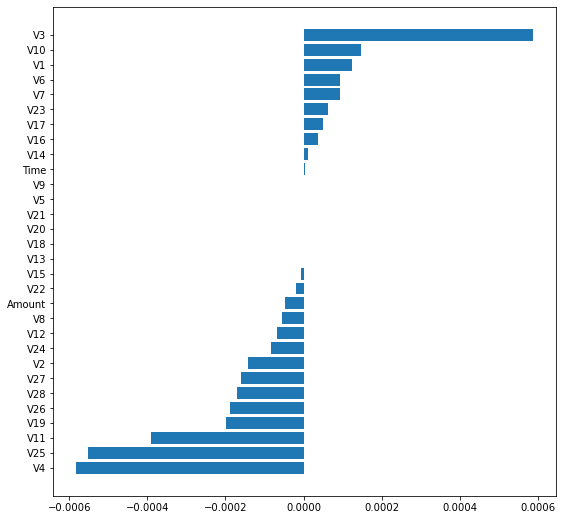

In [60]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

---
## Remove Resources
see notebook "99 - Cleanup"